<font  style="font-size: 3rem; color: darkviolet"> Neural Networks in TensorFlow </font>

DEL - 2023/24 - TP1 

*This assignment is inspired by the Deep Learning course on Coursera by Andrew Ng, Stanford University, for which we are thankful.*

In this assignment, you will learn how to use TensorFlow, a powerful framework that simplifies the creation and training of neural networks. After completing this assignment, you will be proficient in training a neural network using TensorFlow. TensorFlow, along with other tools like Torch, can significantly accelerate your progress in deep learning development.

Resources to understand and work with gradients in TensorFlow:

Introduction to Gradients and Automatic Differentiation: 
https://www.tensorflow.org/guide/autodiff 

GradientTape documentation:
https://www.tensorflow.org/api_docs/python/tf/GradientTape


### Table of Contents
- [1 - Dataset](#1)
- [2 - One Hot Encodings](#2)
- [3 - Parameters Initialization](#3)
- [4 - Building Your First Neural Network in TensorFlow](#4)
    - [4.1 - Forward Propagation](#4.1)
    - [4.2 - Total Loss](#4.2)
    - [4.3 - Training the Model](#4.3)

In [1]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time

You will be using v2.x, for maximum speed and efficiency.

In [2]:
tf.__version__

'2.10.0'

Notes from TEAMS

<a name='1'></a>
## <font color='darkviolet'> 1 - Dataset

The `tf.Tensor` object is a fundamental data structure in TensorFlow used for manipulating and storing numerical data. Tensors are similar to NumPy arrays, as they are multidimensional arrays with specific data types and contain information about the computational graph.
    
You will learn how to utilize a TensorFlow dataset created from an HDF5 file. This is a powerful alternative to using NumPy arrays for storing large datasets, as it enables you to work with streaming data, also known as a TensorFlow data generator.

In [3]:
# Load the training and test datasets
train_dataset = h5py.File('train_signs.h5', "r")
test_dataset = h5py.File('test_signs.h5', "r")

x_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_x'])
y_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_y'])

x_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_x'])
y_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_y'])

TensorFlow datasets are implemented as generators, which means that their contents cannot be accessed directly. Instead, you must iterate over them in a for loop or explicitly create a Python iterator using `iter` and consume its elements using `next`. In addition, you can inspect the `shape` and `dtype` of each element in the dataset using the `element_spec` attribute. This provides a convenient way to understand the structure and data type of the dataset.

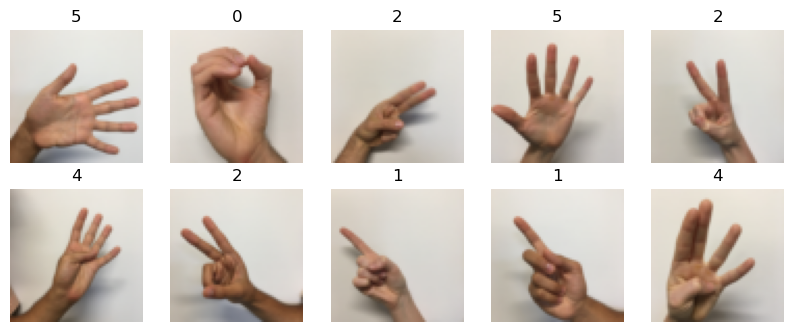

In [4]:
# Example: Display the first 10 images and labels from the training dataset
unique_labels = set()
#convert the labels of the training set in a directly accessible numpy array
for element in y_train:
    #numpy() function converts a tensor object into a numpy.ndarray object
    unique_labels.add(element.numpy())

#create an iterator on the examples of the training set
images_iter = iter(x_train)
#create an iterator on the labels of the training set
labels_iter = iter(y_train)
plt.figure(figsize=(10, 10))
for i in range(10):
    ax = plt.subplot(5, 5, i + 1)
    #adds to the plot the images from the training set
    plt.imshow(next(images_iter).numpy().astype("uint8"))
    #adds to the plot the labels associated to the images
    plt.title(next(labels_iter).numpy().astype("uint8"))
    #remove all the measures from the axis of the plots
    plt.axis("off")

Normalization can improve training efficiency and model convergence, especially for deep neural networks. It ensures that the pixel values have a consistent scale, making them more suitable for mathematical operations and optimization algorithms.

The `normalize` function takes an image tensor, converts its data type, normalizes its pixel values, and flattens it into a 1D tensor.

In [5]:
def normalize(image):

    # Convert the data type of the input image to float32 and normalize its components
    image = tf.cast(image, tf.float32) / 255.0
    
    # Reshape the image tensor into a 1D vector
    image = tf.reshape(image, [-1,])
    
    return image

In TensorFlow datasets, you can use the `map()` method to apply a function to each element of the dataset.

In [6]:
new_train = x_train.map(normalize)
new_test = x_test.map(normalize)

#### <font color='blue'>  Question 1. Describe your dataset. 
<font color='blue'>  What is the shape and data type of the dataset. How many unique classes or labels are there in the dataset? Use the code and steps provided to explore and describe the dataset. Understanding the dataset is a crucial first step in working with any deep learning project.

In [7]:
#access the shape and dtype of the elements of the dataset
print(images_iter.element_spec)
print(labels_iter.element_spec)

TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None)
TensorSpec(shape=(), dtype=tf.int64, name=None)


In [8]:
#find size of the set containing the labels of the dataset, i.e. the total number of labels
print("In total we have " + str(len(unique_labels)) + " labels in the dataset")
#print the labels
print("The labels given in the dataset are: " + str(unique_labels))

In total we have 6 labels in the dataset
The labels given in the dataset are: {0, 1, 2, 3, 4, 5}


<a name='2'></a>
## <font color='darkviolet'> 2 - One Hot Encodings

In deep learning, we often encounter scenarios where labels are represented as a vector with values ranging from $0$ to $C-1$, where $C$ is the number of classes. 
To work with these labels effectively, we use a technique called "one-hot encoding". One-hot encoding ensures that only one element in each row (corresponding to the class) has a value of 1, and the rest are set to 0.
    
If $C$ is for example 4, then you might have the following $y$ vector which you will need to convert like this:

<img src="one_hot.png" style="width:600px;height:150px;">
    
In TensorFlow, we can perform one-hot encoding easily using the `tf.one_hot()` function. This function takes the labels and the total number of classes (depth) as input and returns a one-hot encoded representation of the labels. Additionally, we reshape the resulting tensor to have a single row.
    
`tf.one_hot(labels, depth, axis=0)`https://www.tensorflow.org/api_docs/python/tf/one_hot

<a name='ex-1'></a>
### <font color='blue'> Exercise - one_hot_matrix
    
Implement the function below to take a single label and the total number of classes, $C$, as input. Return the one-hot encoding as a column-wise matrix using tf.one_hot(), and then reshape it using tf.reshape().

In [9]:
def one_hot_matrix(label, depth=6):
    """
    Computes the one hot encoding for a single label

    Arguments:
        label -- (int) Categorical label
        depth -- (int) Number of different classes that label can take

    Returns:
         one_hot -- tf.Tensor A single-row matrix with the one hot encoding.
    """

    #TODO Use the built-in TensorFlow function `tf.one_hot` to compute the one hot encoding for the label.
    one_hot = tf.one_hot(label, depth, axis = 0)
    
    #TODO Reshape the tensor to have a single row and flatten it.
    #the reshape function with [-1] as new shape tells to take whatever shape is currently inside the tensor and convert it into a flat tensor
    one_hot = tf.reshape(one_hot, [-1])

    return one_hot

In [10]:
#debug of the matrix outside of the test function --> error was given by the reshape function call in the one_hot_matrix function
one_hot = one_hot_matrix(tf.constant(1), 4)
print(one_hot)
print(one_hot.shape[0])

tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
4


In [11]:
def one_hot_matrix_test(target):
    label = tf.constant(1)
    depth = 4
    result = target(label, depth)
    print("Test 1:",result)
    assert result.shape[0] == depth, "Use the parameter depth"
    assert np.allclose(result, [0., 1. ,0., 0.] ), "Wrong output. Use tf.one_hot"
    label_2 = [2]
    result = target(label_2, depth)
    print("Test 2:", result)
    assert result.shape[0] == depth, "Use the parameter depth"
    assert np.allclose(result, [0., 0. ,1., 0.] ), "Wrong output. Use tf.reshape as instructed"
    
    print("\033[92mAll test passed")

one_hot_matrix_test(one_hot_matrix)

Test 1: tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
Test 2: tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
All test passed


<a name='3'></a>
## <font color='darkviolet'> 3 - Parameters Initialization

In this step, you will initialize the neural network model parameters using the Glorot initializer. This initializer can be accessed through `tf.keras.initializers.GlorotNormal`.
It draws samples from a truncated normal distribution centered at 0, with a standard deviation of `stddev = sqrt(2 / (fan_in + fan_out))`. Here, `fan_in` is the number of input units, and `fan_out` is the number of output units in the weight tensor.

<a name='ex-2'></a>
### <font color='blue'> Exercise - Glorot initializer

Implement the function below using: 

 - `tf.keras.initializers.GlorotNormal(seed=1)`
 - `tf.Variable(initializer(shape=())`

In [12]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with TensorFlow. The shapes are given:
    
                        W1 : [25, 12288]  --> [hidden layer size, input size]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
                                
    initializer = tf.keras.initializers.GlorotNormal(seed=1)
    
    #TODO initialize parameters for each layer of the neural network
    W1 = tf.Variable(initializer(shape = (25,12288)))
    b1 = tf.Variable(initializer(shape = (25,1))) 
    W2 = tf.Variable(initializer(shape = (12,25)))
    b2 = tf.Variable(initializer(shape = (12,1)))
    W3 = tf.Variable(initializer(shape = (6,12)))
    b3 = tf.Variable(initializer(shape = (6,1)))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters


In [13]:
parameters_debug = initialize_parameters()
print(parameters_debug.keys())
#print(parameters_debug.values())

dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])


In [14]:
def initialize_parameters_test(target):
    parameters = target()

    #dictionary created to test out the shape values of the parameters initialized with the initialize_parameters function
    values = {"W1": (25, 12288),
              "b1": (25, 1),
              "W2": (12, 25),
              "b2": (12, 1),
              "W3": (6, 12),
              "b3": (6, 1)}

    for key in parameters:
        print(f"{key} shape: {tuple(parameters[key].shape)}")
        assert type(parameters[key]) == ResourceVariable, "All parameter must be created using tf.Variable"
        assert tuple(parameters[key].shape) == values[key], f"{key}: wrong shape"
        assert np.abs(np.mean(parameters[key].numpy())) < 0.5,  f"{key}: Use the GlorotNormal initializer"
        assert np.std(parameters[key].numpy()) > 0 and np.std(parameters[key].numpy()) < 1, f"{key}: Use the GlorotNormal initializer"

    print("\033[92mAll test passed")

initialize_parameters_test(initialize_parameters)

W1 shape: (25, 12288)
b1 shape: (25, 1)
W2 shape: (12, 25)
b2 shape: (12, 1)
W3 shape: (6, 12)
b3 shape: (6, 1)
All test passed


<a name='4'></a>
## <font color='darkviolet'> 4 - Building Your First Neural Network in TensorFlow

In this section, we'll guide you through the process of building a neural network using TensorFlow. This process involves two major steps: i) implementing forward propagation and ii) retrieving the gradients.

<a name='4.1'></a>
### <font color='darkviolet'> 4.1 - Forward Propagation 

TensorFlow simplifies neural network construction by automatically tracking operations for backpropagation. You only need to implement the forward propagation function and it will keep track of the operations you did to calculate the back propagation automatically.  

<a name='ex-5'></a>
### <font color='blue'> Exercise - forward_propagation

Your task is to implement the `forward_propagation` function using only TensorFlow API functions. Here are the functions you should use:
- `tf.math.add`
- `tf.linalg.matmul`
- `tf.keras.activations.relu`

In [15]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR
    Args:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- dictionary containing the parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    #TODO
    #tf.math.add: adds a scalar to a list (used to add the bias to our vectors)
    #tf.linalg.matmul: multiplies two matrices given in input, can set a parameter to transpose the matrices
    #tf.keras.activations.relu: applies ReLU activation function
    #for each layer we have we apply the two steps of forward propagation
    Z1_mul = tf.linalg.matmul(W1, X)
    Z1 = tf.math.add(b1, Z1_mul)
    A1 = tf.keras.activations.relu(Z1)

    Z2_mul = tf.linalg.matmul(W2, A1)
    Z2 = tf.math.add(b2, Z2_mul)
    A2 = tf.keras.activations.relu(Z2)

    Z3_mul = tf.linalg.matmul(W3, A2)
    Z3 = tf.math.add(b3, Z3_mul)
    #A2 = tf.keras.activations.relu(Z2)

    return Z3


In [16]:
def forward_propagation_test(target, examples):
    minibatches = examples.batch(2)
    parametersk = initialize_parameters()
    W1 = parametersk['W1']
    b1 = parametersk['b1']
    W2 = parametersk['W2']
    b2 = parametersk['b2']
    W3 = parametersk['W3']
    b3 = parametersk['b3']
    index = 0
    minibatch = list(minibatches)[0]
    with tf.GradientTape() as tape:
        forward_pass = target(tf.transpose(minibatch), parametersk)
        print(forward_pass)
        fake_cost = tf.reduce_mean(forward_pass - np.ones((6,2)))

        assert type(forward_pass) == EagerTensor, "Your output is not a tensor"
        assert forward_pass.shape == (6, 2), "Last layer must use W3 and b3"
        assert np.allclose(forward_pass, 
                           [[-0.13430887,  0.14086473],
                            [ 0.21588647, -0.02582335],
                            [ 0.7059658,   0.6484556 ],
                            [-1.1260961,  -0.9329492 ],
                            [-0.20181894, -0.3382722 ],
                            [ 0.9558965,   0.94167566]]), "Output does not match"
    index = index + 1
    trainable_variables = [W1, b1, W2, b2, W3, b3]
    grads = tape.gradient(fake_cost, trainable_variables)
    assert not(None in grads), "Wrong gradients. It could be due to the use of tf.Variable whithin forward_propagation"
    print("\033[92mAll test passed")

forward_propagation_test(forward_propagation, new_train)

tf.Tensor(
[[-0.1343086   0.14086485]
 [ 0.21588635 -0.02582332]
 [ 0.7059655   0.6484555 ]
 [-1.1260959  -0.93294895]
 [-0.20181894 -0.33827233]
 [ 0.95589614  0.9416754 ]], shape=(6, 2), dtype=float32)


All test passed


#### <font color='blue'> Question 2. What does the ReLU activation function do in a neural network?
#### <font color='green'> It transforms the output of a layer into a value in the [0,1] interval for binary classification problems
    
#### <font color='blue'> Question 3. What are the Numpy equivalents of the TODO lines in the forward_propagation function?
#### <font color='green'> We use:
    - np.matmul for matrix multiplication
    - np.add to sum a matrix and a scalar
    - np.maximum(0, x) to replace the ReLU function

<a name='4.2'></a>
### <font color='darkviolet'> 4.2 - Total Loss

In this multi-class classification problem, we will use categorical cross-entropy as the loss function. Categorical cross-entropy is a measure of dissimilarity between predicted class probabilities and true labels. These predicted probabilities are generated using the softmax function. 

To compute the overall cost, which sums the losses over the entire batch of samples and then divides the sum by the total number of samples, we'll follow a two-step process. In step 1, the `compute_total_loss` function will sum the losses from one mini-batch of samples. As you train the model, step 2 will accumulate the sums from each of the mini-batches, and finish by dividing the sum by the total number of samples to get the final cost value.
    
The final total loss serves for backpropagation and model parameter optimization during the training process.

Note: using the "total loss" instead of the "mean loss" in step 1 ensures that the final cost value remains consistent. For example, if the mini-batch size is 4, but there are only 5 samples in the whole batch, then the last mini-batch will have only 1 sample. Consider a scenario where the losses for the 5 samples are [0, 1, 2, 3, 4], respectively. The final cost should be their average, which is 2. By adopting the "total loss" approach, we obtain the same answer. However, the "mean loss" approach would give us 1.5 and 4 for the two mini-batches, and then an average of 2.75, which is different from the desired result of 2. Therefore, we adopt the "total loss" approach here.

<a name='ex-6'></a>
### <font color='blue'> Exercise - compute_total_loss
    
Implement the total loss function below. You will use it to compute the total loss of a batch of samples.

- `tf.nn.softmax_cross_entropy_with_logits` applies the softmax function to the logits to obtain the predicted probability distribution and then computes the cross-entropy loss between the predicted distribution and the true distribution.

- `tf.reduce_sum` performs the summation over the examples.

In [17]:
def compute_total_loss(logits, labels):
    """
    Computes the total loss
    
    Arguments:
    logits -- output of forward propagation (output of the last LINEAR unit), of shape (num_examples, num_classes)
    labels -- "true" labels vector, same shape as logits
    
    Returns:
    total_loss - Tensor of the total loss value
    """
    
    #TODO compute the individual losses using tf.nn.softmax_cross_entropy_with_logits()
    #specify axis=0 because by default the function was using axis=-1 which means that it was taking the last axis, i.e. axis = 1
    losses = tf.nn.softmax_cross_entropy_with_logits(labels, logits, axis=0)
    
    #TODO compute the total loss as the sum of the individual losses
    total_loss = tf.reduce_sum(losses)
    
    return total_loss

In [18]:
def compute_total_loss_test(target, Y):
    pred = tf.constant([[ 2.4048107,   5.0334096 ],
             [-0.7921977,  -4.1523376 ],
             [ 0.9447198,  -0.46802214],
             [ 1.158121,    3.9810789 ],
             [ 4.768706,    2.3220146 ],
             [ 6.1481323,   3.909829  ]])
    minibatches = Y.batch(2)
    for minibatch in minibatches:
        result = target(pred, tf.transpose(minibatch))
        break
        
    print(result)
    assert(type(result) == EagerTensor), "Use the TensorFlow API"
    assert (np.abs(result - (0.50722074 + 1.1133534) / 2.0) < 1e-7), "Test does not match. Did you get the reduce sum of your loss functions?"

    print("\033[92mAll test passed")

#new_Y train is given by normalization of training and test set
#this can be done e.g. using one hot encoding for normalization: new_y_train = y_train.map(one_hot_matrix)
new_y_train = y_train.map(one_hot_matrix)
compute_total_loss_test(compute_total_loss, new_y_train)

tf.Tensor(0.810287, shape=(), dtype=float32)
All test passed


<a name='4.3'></a>
### <font color='darkviolet'> 3.3 - Training the Model

When training a model, you need to use an optimizer to update the parameters of the model and improve its accuracy. You can specify the type of optimizer you want to use in just one line of code, for example `tf.keras.optimizers.Adam`. There are other types of optimizers you can use, such as SGD.

Next, you'll use the `tape.gradient` function to calculate the gradients of the loss function with respect to the model's parameters. Then, you'll call the optimizer's `apply_gradients` method to update the model's parameters using the calculated gradients.

An extra step has been added to the batch training process: `tf.Data.dataset = dataset.prefetch(8`). This step helps prevent a memory bottleneck that can occur when reading data from disk. By prefetching the data, you can keep it ready for when it's needed and process it in smaller, more manageable pieces to improve efficiency.
    
<a name='ex-7'></a>
### <font color='blue'> Exercise - Implement the model function.
    
Complete the code as indicated.

In [19]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001,
          num_epochs=1500, minibatch_size=32, print_cost=True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (number of training examples, input size)
    Y_train -- training labels, of shape (number of training examples, output size)
    X_test -- test set, of shape (number of test examples, input size)
    Y_test -- test labels, of shape (number of test examples, output size)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 10 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    costs -- list of costs over the training epochs
    train_acc -- list of training accuracies over the training epochs
    test_acc -- list of test accuracies over the training epochs
    """

    # Initialize cost and accuracy lists
    costs = []                                      
    train_acc = []
    test_acc = []
    
    
    #TODO Initialize parameters
    parameters = initialize_parameters()

    
    # Unpack the initialized parameters into individual variables
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    
    #TODO Adam optimizer: warning suggested to use the legacy version on M2
    optimizer = tf.keras.optimizers.legacy.Adam()
    
    
    # Create accuracy metrics
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    # Create TensorFlow datasets for the training and test sets
    dataset = tf.data.Dataset.zip((X_train, Y_train))
    test_dataset = tf.data.Dataset.zip((X_test, Y_test))
    
    # Get the number of training examples
    m = dataset.cardinality().numpy()
    
    # Create minibatches of the training and test datasets
    minibatches = dataset.batch(minibatch_size).prefetch(8)
    test_minibatches = test_dataset.batch(minibatch_size).prefetch(8)

    # Training loop
    for epoch in range(num_epochs):
        
        epoch_total_loss = 0.
        
        # Reset accuracy at each epoch
        train_accuracy.reset_states()

        # Iterate through each minibatch in the training set
        for (minibatch_X, minibatch_Y) in minibatches:
            
            # Use a gradient tape to record gradients for backpropagation
            with tf.GradientTape() as tape:
                
                
                #TODO 1. Perform forward propagation
                Z3 = forward_propagation(tf.transpose(minibatch_X), parameters)
                #TODO 2. Compute the loss
                minibatch_total_loss = compute_total_loss(Z3, tf.transpose(minibatch_Y))

                
            # Update accuracy metric for this minibatch
            train_accuracy.update_state(minibatch_Y, tf.transpose(Z3))

            # Compute gradients and update parameters using the optimizer
            #gradients are used for the gradient descent function
            trainable_variables = [W1, b1, W2, b2, W3, b3]
            grads = tape.gradient(minibatch_total_loss, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))

            # Add the minibatch loss to the epoch total
            epoch_total_loss += minibatch_total_loss

            
        #TODO Compute the average total loss of the current epoch
        epoch_total_loss = epoch_total_loss/num_epochs

        
        # Print the cost every 10 epochs
        if print_cost and epoch % 10 == 0:
            print(f"Cost after epoch {epoch}: {epoch_total_loss:.4f}")
            print(f"Train accuracy: {train_accuracy.result():.4f}")

            # Compute accuracy on the test set
            test_accuracy.reset_states() # reset accuracy at each evaluation
            for (minibatch_X, minibatch_Y) in test_minibatches:
                Z3 = forward_propagation(tf.transpose(minibatch_X), parameters)
                test_accuracy.update_state(minibatch_Y, tf.transpose(Z3))
            print(f"Test accuracy: {test_accuracy.result():.4f}")

            # Record cost and accuracy metrics
            costs.append(epoch_total_loss)
            train_acc.append(train_accuracy.result())
            test_acc.append(test_accuracy.result())

    return parameters, costs, train_acc, test_acc


In [20]:
#encode the labels of the test set into one hot
new_y_test = y_test.map(one_hot_matrix)

parameters, costs, train_acc, test_acc = model(new_train, new_y_train, new_test, new_y_test, num_epochs=100)

Cost after epoch 0: 22.4361
Train accuracy: 0.1954
Test accuracy: 0.1917
Cost after epoch 10: 14.9222
Train accuracy: 0.4176
Test accuracy: 0.4250
Cost after epoch 20: 12.9216
Train accuracy: 0.4852
Test accuracy: 0.5167
Cost after epoch 30: 11.5197
Train accuracy: 0.5278
Test accuracy: 0.5667
Cost after epoch 40: 10.4266
Train accuracy: 0.5833
Test accuracy: 0.5917
Cost after epoch 50: 9.4614
Train accuracy: 0.6176
Test accuracy: 0.6000
Cost after epoch 60: 8.6909
Train accuracy: 0.6528
Test accuracy: 0.5917
Cost after epoch 70: 8.7955
Train accuracy: 0.6426
Test accuracy: 0.6000
Cost after epoch 80: 8.4912
Train accuracy: 0.6519
Test accuracy: 0.6333
Cost after epoch 90: 8.2001
Train accuracy: 0.6657
Test accuracy: 0.6583


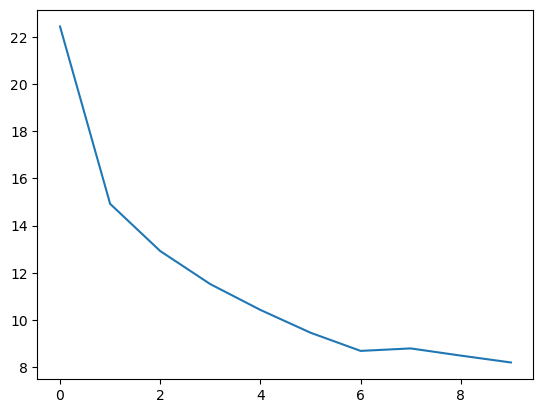

In [21]:
#TO DO Plot the cost
plt.plot(costs)

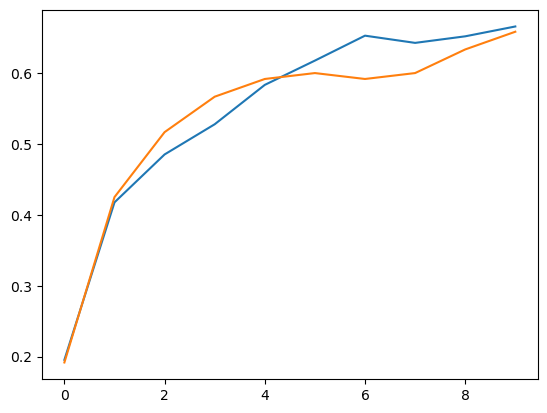

In [22]:
#TO DO Plot the train accuracy
plt.plot(train_acc)

#TO DO Plot the test accuracy
plt.plot(test_acc)

#### <font color='blue'> Question 4. What is the architecture of the neural network ?
#### <font color='green'> The architecture of the NN is made by a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX, i.e. two hidden layers with ReLU activation function and the output layer with a softmax function. We use an Adam optimization function
#### <font color='blue'> Question 5. What are the metrics used to evaluate the training and test accuracy ?
#### <font color='green'> We calculate the total loss for each minibatch calculated using the cross-entropy loss function and then we compute the average loss function for the entire epoch
#### <font color='blue'> Question 6. What are the main computations performed at each epoch ?
#### <font color='green'> At each epoch the main computations are the gradients and the total and average loss for the epoch
#### <font color='blue'> Question 7. What is the purpose of prefetching the minibatches ?
#### <font color='green'> This step helps prevent a memory bottleneck that can occur when reading data from disk. By prefetching the data, you can keep it ready for when it's needed and process it in smaller, more manageable pieces to improve efficiency.